In [25]:
#imports
import pandas as pd
import numpy as np
import s3fs

In [26]:
# Import Data

fs = s3fs.S3FileSystem()
s3_location = "s3://ecb-hackathon-data-group08-x19s00/climate_data_full/soil_mosture_anomaly/"
all_files = fs.ls(s3_location)

SMA_combined = pd.DataFrame()

all_dfs = []

for file in all_files:
    if file.endswith("csv"):
        file_name = file.split("/")[-1]
        year = file_name.split("_")[-1].split(".")[0]
        
        sma_yearly = pd.read_csv(f"s3://{file}")
        sma_yearly["year"] = year
        # column names has whitespaces around
        sma_yearly.rename(columns=lambda x: x.strip(), inplace=True)
        all_dfs.append(sma_yearly)
        
SMA_combined = pd.concat(all_dfs)

In [27]:
SMA_combined.describe()
SMA_combined.head()

NUTS_CODE   TIMESTAMP  MEDIAN  year
0        AD  2001-01-01   0.815  2001
1     AL011  2001-01-01  -0.324  2001
2     AL012  2001-01-01   0.735  2001
3     AL013  2001-01-01   0.573  2001
4     AL014  2001-01-01   0.785  2001

In [28]:
# get Long term average values of relevant metrics (LTA )
def getLTA(dataset,aggregationfunction,suffix):
    LTA = pd.pivot_table(dataset,
                         values=['MEDIAN'],
                         columns=['NUTS_CODE'],
                         aggfunc=[aggregationfunction] )
    LTA = LTA.T
    LTA = LTA.droplevel(0)
    LTA = LTA.add_suffix(suffix)
    return LTA

LTA = getLTA(SMA_combined,np.mean,'_LTA_mean')

extraLTA = getLTA(SMA_combined,np.std,'_LTA_std')
LTA = pd.merge(LTA,extraLTA,on=['NUTS_CODE'])

extraLTA = getLTA(SMA_combined,np.min,'_LTA_min')
LTA = pd.merge(LTA,extraLTA,on=['NUTS_CODE'])

extraLTA = getLTA(SMA_combined,np.max,'_LTA_max')
LTA = pd.merge(LTA,extraLTA,on=['NUTS_CODE'])

LTA = LTA.add_prefix("SMA_")
LTA.reset_index(inplace=True)

In [29]:
LTA

NUTS_CODE  SMA_MEDIAN_LTA_mean  SMA_MEDIAN_LTA_std  SMA_MEDIAN_LTA_min  \
0           AD            -0.115735            0.803317              -3.087   
1        AL011            -0.060212            0.465723              -1.808   
2        AL012            -0.125462            0.807136              -2.984   
3        AL013            -0.050307            0.862894              -3.745   
4        AL014            -0.140295            0.845784              -2.424   
...        ...                  ...                 ...                 ...   
1493     UKN0C            -0.006045            0.893845              -7.848   
1494     UKN0D             0.032727            0.794348              -4.757   
1495     UKN0E            -0.049360            0.853164              -2.591   
1496     UKN0F             0.052455            0.830940              -6.919   
1497     UKN0G             0.006333            0.759347              -4.200   

      SMA_MEDIAN_LTA_max  
0                  1.426  
1                  2.158  
2                  2.016  
3                  1.738  
4                  2.018  
...                  ...  
1493               1.841  
1494               1.633  
1495               2.156  
1496               1.809  
1497               2.216  

[1498 rows x 5 columns]

In [30]:
# Compute aggregated basic variables (mean, std, ... by year by region
SMA_aggregated = SMA_combined.groupby(['year','NUTS_CODE']).agg({'MEDIAN':'mean'})
SMA_aggregated = SMA_aggregated.add_suffix('_mean')

additional_variable = SMA_combined.groupby(['year','NUTS_CODE']).agg({'MEDIAN':'std'})
additional_variable = additional_variable.add_suffix('_std')
SMA_aggregated = pd.merge(SMA_aggregated,additional_variable,on=['year','NUTS_CODE'])

SMA_combined_count = SMA_combined 
SMA_combined_count['MEDIAN'] = np.where(SMA_combined_count['MEDIAN'] < -1, 1, 0)
additional_variable = SMA_combined_count.groupby(['year','NUTS_CODE']).agg({'MEDIAN':'sum'})
additional_variable = additional_variable.add_suffix('_count')
SMA_aggregated = pd.merge(SMA_aggregated,additional_variable,on=['year','NUTS_CODE'])

additional_variable = SMA_combined.groupby(['year','NUTS_CODE']).agg({'MEDIAN':'max'})
additional_variable = additional_variable.add_suffix('_max')
SMA_aggregated = pd.merge(SMA_aggregated,additional_variable,on=['year','NUTS_CODE'])

additional_variable = SMA_combined.groupby(['year','NUTS_CODE']).agg({'MEDIAN':'min'})
additional_variable = additional_variable.add_suffix('_min')
SMA_aggregated = pd.merge(SMA_aggregated,additional_variable,on=['year','NUTS_CODE'])

SMA_aggregated = SMA_aggregated.add_prefix('SMA_')

In [31]:
# Construct "quarterly" variables
SMA_aggregated.reset_index(inplace=True)

In [32]:
SMA_aggregated_LTA = pd.merge(SMA_aggregated, LTA, on=['NUTS_CODE'], how='left')

In [33]:
SMA_aggregated_LTA['SMA_MEDIAN_Average_Deviation_LTA'] = (
    SMA_aggregated_LTA['SMA_MEDIAN_mean'] 
    - SMA_aggregated_LTA['SMA_MEDIAN_LTA_mean'] )


In [34]:
SMA_aggregated_LTA

year NUTS_CODE  SMA_MEDIAN_mean  SMA_MEDIAN_std  SMA_MEDIAN_count  \
0      2001        AD        -0.284667        0.869501                 4   
1      2001     AL011        -0.273417        0.373725                 0   
2      2001     AL012         0.159667        0.565980                 0   
3      2001     AL013         0.118833        0.494665                 0   
4      2001     AL014         0.162833        0.612252                 0   
...     ...       ...              ...             ...               ...   
32951  2022     UKN0C        -0.448417        0.735171                 2   
32952  2022     UKN0D        -0.286500        0.850064                 3   
32953  2022     UKN0E        -0.365250        0.874395                 2   
32954  2022     UKN0F        -0.227917        0.708496                 2   
32955  2022     UKN0G        -0.258833        0.668485                 1   

       SMA_MEDIAN_max  SMA_MEDIAN_min  SMA_MEDIAN_LTA_mean  \
0                   1               0            -0.115735   
1                   0               0            -0.060212   
2                   0               0            -0.125462   
3                   0               0            -0.050307   
4                   0               0            -0.140295   
...               ...             ...                  ...   
32951               1               0            -0.006045   
32952               1               0             0.032727   
32953               1               0            -0.049360   
32954               1               0             0.052455   
32955               1               0             0.006333   

       SMA_MEDIAN_LTA_std  SMA_MEDIAN_LTA_min  SMA_MEDIAN_LTA_max  \
0                0.803317              -3.087               1.426   
1                0.465723              -1.808               2.158   
2                0.807136              -2.984               2.016   
3                0.862894              -3.745               1.738   
4                0.845784              -2.424               2.018   
...                   ...                 ...                 ...   
32951            0.893845              -7.848               1.841   
32952            0.794348              -4.757               1.633   
32953            0.853164              -2.591               2.156   
32954            0.830940              -6.919               1.809   
32955            0.759347              -4.200               2.216   

       SMA_MEDIAN_Average_Deviation_LTA  
0                             -0.168932  
1                             -0.213205  
2                              0.285129  
3                              0.169140  
4                              0.303129  
...                                 ...  
32951                         -0.442371  
32952                         -0.319227  
32953                         -0.315890  
32954                         -0.280371  
32955                         -0.265167  

[32956 rows x 12 columns]

In [35]:
column_names = SMA_aggregated_LTA.columns
column_names

Index(['year', 'NUTS_CODE', 'SMA_MEDIAN_mean', 'SMA_MEDIAN_std',
       'SMA_MEDIAN_count', 'SMA_MEDIAN_max', 'SMA_MEDIAN_min',
       'SMA_MEDIAN_LTA_mean', 'SMA_MEDIAN_LTA_std', 'SMA_MEDIAN_LTA_min',
       'SMA_MEDIAN_LTA_max', 'SMA_MEDIAN_Average_Deviation_LTA'],
      dtype='object')

In [36]:
# output to combine with other datasets
#SMA_aggregated_LTA['NUTS_ID'] = SMA_aggregated_LTA.index

# SMA_aggregated_LTA.describe()
SMA_aggregated_LTA



year NUTS_CODE  SMA_MEDIAN_mean  SMA_MEDIAN_std  SMA_MEDIAN_count  \
0      2001        AD        -0.284667        0.869501                 4   
1      2001     AL011        -0.273417        0.373725                 0   
2      2001     AL012         0.159667        0.565980                 0   
3      2001     AL013         0.118833        0.494665                 0   
4      2001     AL014         0.162833        0.612252                 0   
...     ...       ...              ...             ...               ...   
32951  2022     UKN0C        -0.448417        0.735171                 2   
32952  2022     UKN0D        -0.286500        0.850064                 3   
32953  2022     UKN0E        -0.365250        0.874395                 2   
32954  2022     UKN0F        -0.227917        0.708496                 2   
32955  2022     UKN0G        -0.258833        0.668485                 1   

       SMA_MEDIAN_max  SMA_MEDIAN_min  SMA_MEDIAN_LTA_mean  \
0                   1               0            -0.115735   
1                   0               0            -0.060212   
2                   0               0            -0.125462   
3                   0               0            -0.050307   
4                   0               0            -0.140295   
...               ...             ...                  ...   
32951               1               0            -0.006045   
32952               1               0             0.032727   
32953               1               0            -0.049360   
32954               1               0             0.052455   
32955               1               0             0.006333   

       SMA_MEDIAN_LTA_std  SMA_MEDIAN_LTA_min  SMA_MEDIAN_LTA_max  \
0                0.803317              -3.087               1.426   
1                0.465723              -1.808               2.158   
2                0.807136              -2.984               2.016   
3                0.862894              -3.745               1.738   
4                0.845784              -2.424               2.018   
...                   ...                 ...                 ...   
32951            0.893845              -7.848               1.841   
32952            0.794348              -4.757               1.633   
32953            0.853164              -2.591               2.156   
32954            0.830940              -6.919               1.809   
32955            0.759347              -4.200               2.216   

       SMA_MEDIAN_Average_Deviation_LTA  
0                             -0.168932  
1                             -0.213205  
2                              0.285129  
3                              0.169140  
4                              0.303129  
...                                 ...  
32951                         -0.442371  
32952                         -0.319227  
32953                         -0.315890  
32954                         -0.280371  
32955                         -0.265167  

[32956 rows x 12 columns]

In [37]:
# plot SMA on maps
import geopandas as gpd 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

%matplotlib inline

def plotDfAsMap(df,columnname,title):
    #ax= df.plot(figsize=(10,10))
    ax=df.plot(cmap='RdBu',column=columnname)
    minx, miny, maxx, maxy = 20e5, 10e5, 80e5, 70e5
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    ax.margins(0)
    ax.set_title(title)
    plt.show()

# https://matplotlib.org/stable/users/explain/colors/colormaps.html

In [38]:
#Read shapefiles
world_data = gpd.read_file(r's3://ecb-hackathon-data-group08-x19s00/economic_data_full/regional_boundaries/NUTS_RG_20M_2021_3035.shp') 
world_data = world_data[world_data.LEVL_CODE==3]

# try to combine with dataset

world_data.sort_values(by=['NUTS_ID'])
world_data.insert(0, "NUTS_CODE", world_data['NUTS_ID'])


year = "2001"
SMA_aggregated_LTA_selection = SMA_aggregated_LTA[SMA_aggregated_LTA.year==year]
SMA_aggregated_LTA

year NUTS_CODE  SMA_MEDIAN_mean  SMA_MEDIAN_std  SMA_MEDIAN_count  \
0      2001        AD        -0.284667        0.869501                 4   
1      2001     AL011        -0.273417        0.373725                 0   
2      2001     AL012         0.159667        0.565980                 0   
3      2001     AL013         0.118833        0.494665                 0   
4      2001     AL014         0.162833        0.612252                 0   
...     ...       ...              ...             ...               ...   
32951  2022     UKN0C        -0.448417        0.735171                 2   
32952  2022     UKN0D        -0.286500        0.850064                 3   
32953  2022     UKN0E        -0.365250        0.874395                 2   
32954  2022     UKN0F        -0.227917        0.708496                 2   
32955  2022     UKN0G        -0.258833        0.668485                 1   

       SMA_MEDIAN_max  SMA_MEDIAN_min  SMA_MEDIAN_LTA_mean  \
0                   1               0            -0.115735   
1                   0               0            -0.060212   
2                   0               0            -0.125462   
3                   0               0            -0.050307   
4                   0               0            -0.140295   
...               ...             ...                  ...   
32951               1               0            -0.006045   
32952               1               0             0.032727   
32953               1               0            -0.049360   
32954               1               0             0.052455   
32955               1               0             0.006333   

       SMA_MEDIAN_LTA_std  SMA_MEDIAN_LTA_min  SMA_MEDIAN_LTA_max  \
0                0.803317              -3.087               1.426   
1                0.465723              -1.808               2.158   
2                0.807136              -2.984               2.016   
3                0.862894              -3.745               1.738   
4                0.845784              -2.424               2.018   
...                   ...                 ...                 ...   
32951            0.893845              -7.848               1.841   
32952            0.794348              -4.757               1.633   
32953            0.853164              -2.591               2.156   
32954            0.830940              -6.919               1.809   
32955            0.759347              -4.200               2.216   

       SMA_MEDIAN_Average_Deviation_LTA  
0                             -0.168932  
1                             -0.213205  
2                              0.285129  
3                              0.169140  
4                              0.303129  
...                                 ...  
32951                         -0.442371  
32952                         -0.319227  
32953                         -0.315890  
32954                         -0.280371  
32955                         -0.265167  

[32956 rows x 12 columns]

In [39]:
#Read shapefiles
world_data = gpd.read_file(r's3://ecb-hackathon-data-group08-x19s00/economic_data_full/regional_boundaries/NUTS_RG_20M_2021_3035.shp') 
world_data = world_data[world_data.LEVL_CODE==3]

# try to combine with dataset

world_data.sort_values(by=['NUTS_ID'])
world_data.insert(0, "NUTS_CODE", world_data['NUTS_ID'])
#world_data['NUTS_CODE'] = world_data['NUTS_ID']
year = "2001"
SMA_aggregated_LTA_selection = SMA_aggregated_LTA[SMA_aggregated_LTA.year==year]
plot_data = pd.merge(world_data,SMA_aggregated_LTA_selection,on=['NUTS_CODE'],how='right')

In [40]:
plot_data

NUTS_CODE NUTS_ID  LEVL_CODE CNTR_CODE                 NAME_LATN  \
0           AD     NaN        NaN       NaN                       NaN   
1        AL011   AL011        3.0        AL                     Dibër   
2        AL012   AL012        3.0        AL                    Durrës   
3        AL013   AL013        3.0        AL                     Kukës   
4        AL014   AL014        3.0        AL                     Lezhë   
...        ...     ...        ...       ...                       ...   
1493     UKN0C   UKN0C        3.0        UK  Causeway Coast and Glens   
1494     UKN0D   UKN0D        3.0        UK   Antrim and Newtownabbey   
1495     UKN0E   UKN0E        3.0        UK   Lisburn and Castlereagh   
1496     UKN0F   UKN0F        3.0        UK       Mid and East Antrim   
1497     UKN0G   UKN0G        3.0        UK       Fermanagh and Omagh   

                     NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  ...  \
0                          NaN         NaN        NaN         NaN    NaN  ...   
1                        Dibër         4.0        3.0         3.0  AL011  ...   
2                       Durrës         4.0        2.0         1.0  AL012  ...   
3                        Kukës         4.0        3.0         3.0  AL013  ...   
4                        Lezhë         4.0        3.0         1.0  AL014  ...   
...                        ...         ...        ...         ...    ...  ...   
1493  Causeway Coast and Glens         4.0        3.0         1.0  UKN0C  ...   
1494   Antrim and Newtownabbey         4.0        2.0         1.0  UKN0D  ...   
1495   Lisburn and Castlereagh         4.0        2.0         2.0  UKN0E  ...   
1496       Mid and East Antrim         4.0        2.0         1.0  UKN0F  ...   
1497       Fermanagh and Omagh         4.0        3.0         2.0  UKN0G  ...   

     SMA_MEDIAN_mean SMA_MEDIAN_std  SMA_MEDIAN_count  SMA_MEDIAN_max  \
0          -0.284667       0.869501                 4               1   
1          -0.273417       0.373725                 0               0   
2           0.159667       0.565980                 0               0   
3           0.118833       0.494665                 0               0   
4           0.162833       0.612252                 0               0   
...              ...            ...               ...             ...   
1493       -0.599333       0.499912                 2               1   
1494       -0.086167       0.462079                 0               0   
1495       -0.086167       0.416585                 0               0   
1496       -0.317250       0.421249                 0               0   
1497       -0.005917       0.529042                 1               1   

      SMA_MEDIAN_min  SMA_MEDIAN_LTA_mean  SMA_MEDIAN_LTA_std  \
0                  0            -0.115735            0.803317   
1                  0            -0.060212            0.465723   
2                  0            -0.125462            0.807136   
3                  0            -0.050307            0.862894   
4                  0            -0.140295            0.845784   
...              ...                  ...                 ...   
1493               0            -0.006045            0.893845   
1494               0             0.032727            0.794348   
1495               0            -0.049360            0.853164   
1496               0             0.052455            0.830940   
1497               0             0.006333            0.759347   

      SMA_MEDIAN_LTA_min  SMA_MEDIAN_LTA_max  SMA_MEDIAN_Average_Deviation_LTA  
0                 -3.087               1.426                         -0.168932  
1                 -1.808               2.158                         -0.213205  
2                 -2.984               2.016                          0.285129  
3                 -3.745               1.738                          0.169140  
4                 -2.424               2.018                          0.303129  
...        

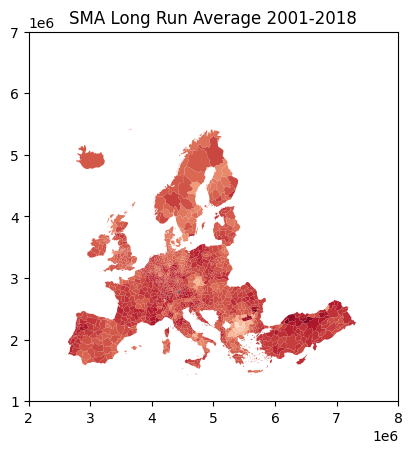

In [41]:
plotDfAsMap(plot_data,'SMA_MEDIAN_LTA_mean','SMA Long Run Average 2001-2018')

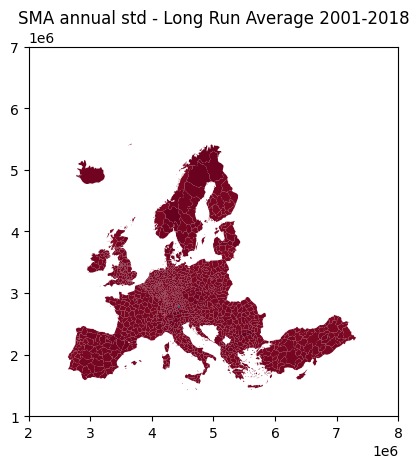

In [42]:
plotDfAsMap(plot_data,'SMA_MEDIAN_LTA_std','SMA annual std - Long Run Average 2001-2018')

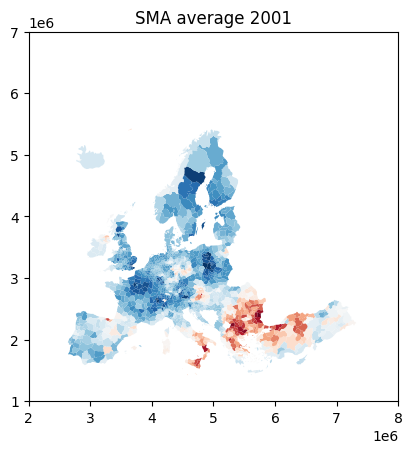

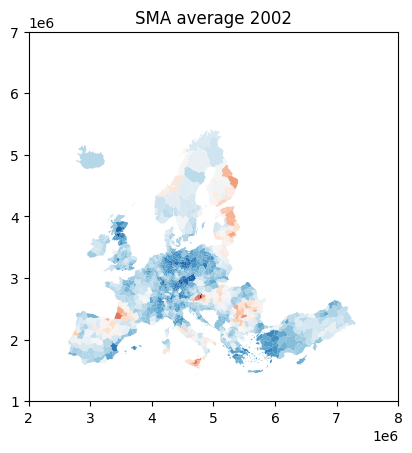

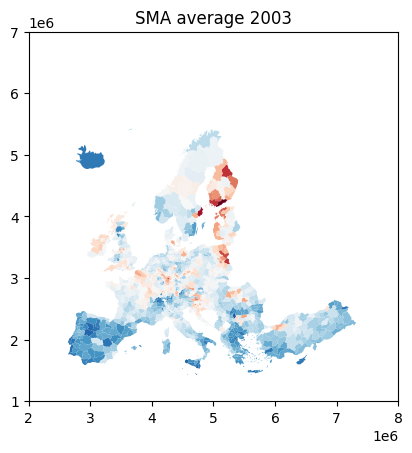

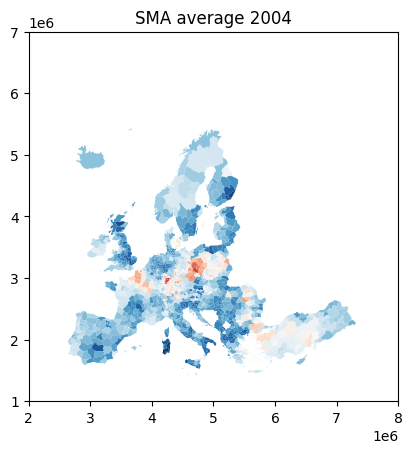

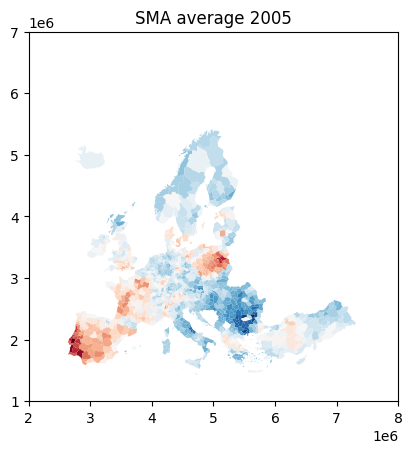

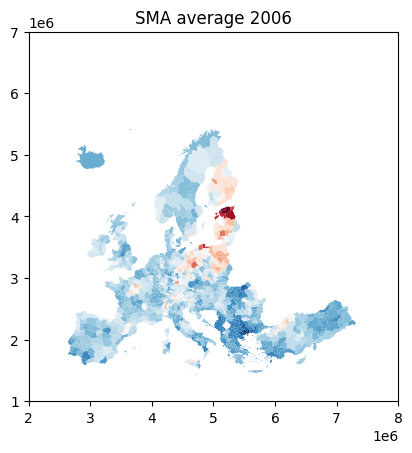

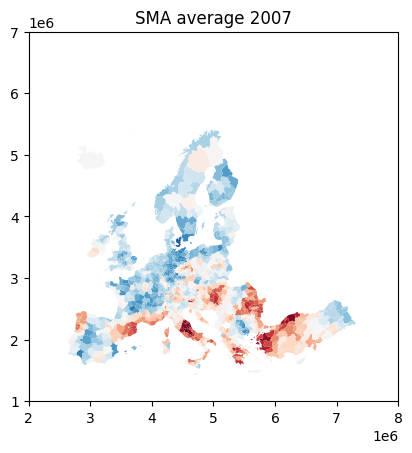

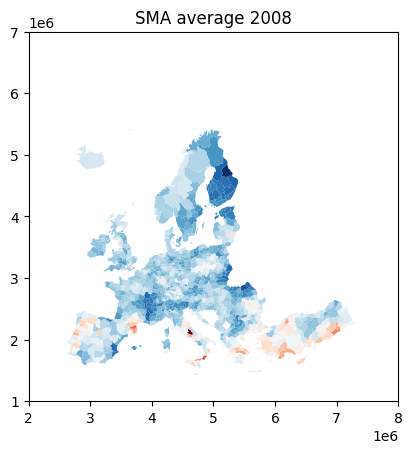

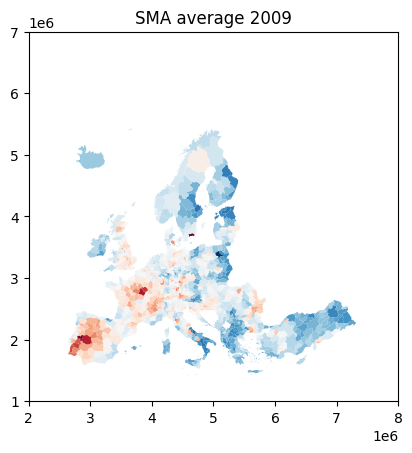

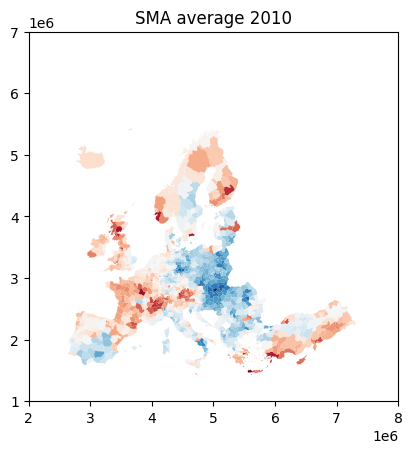

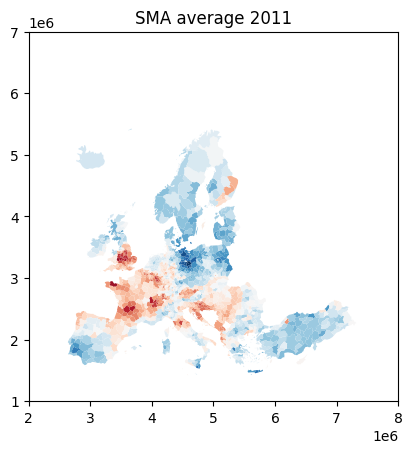

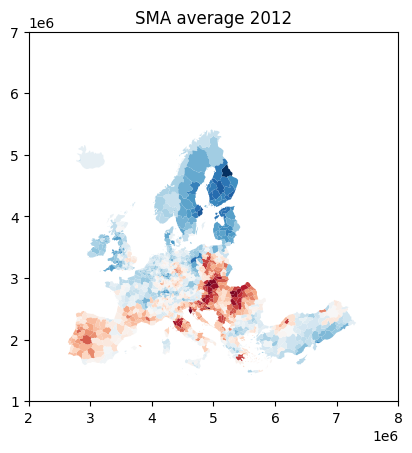

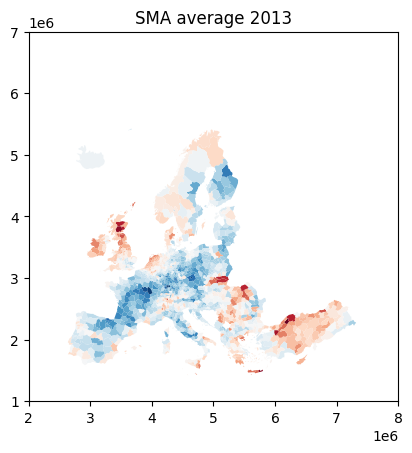

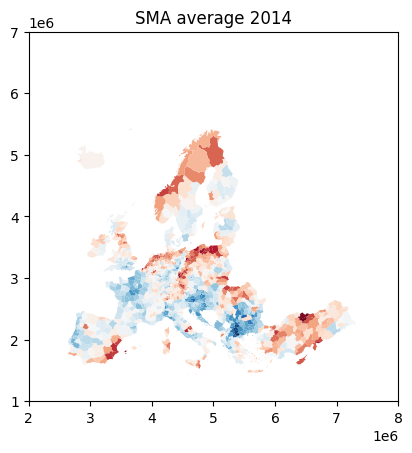

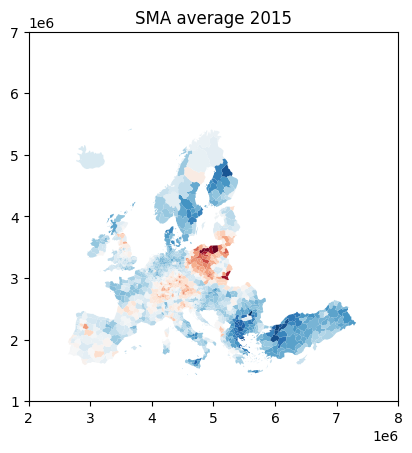

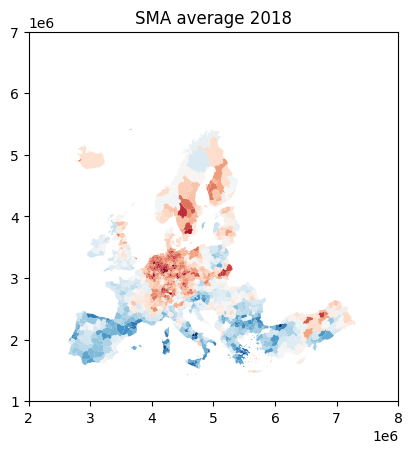

In [43]:
year = 2001
while year <=2018:
    SMA_aggregated_LTA_selection = SMA_aggregated_LTA[SMA_aggregated_LTA.year==str(year)]
    plot_data = pd.merge(world_data,SMA_aggregated_LTA_selection,on=['NUTS_CODE'],how='right')
    plotDfAsMap(plot_data,'SMA_MEDIAN_mean','SMA average ' + str(year))
    year += 1

**Export**

In [44]:
SMA_aggregated_LTA['year'] = pd.to_datetime(SMA_aggregated_LTA['year']).dt.year
SMA_aggregated_LTA = SMA_aggregated_LTA.rename(columns={'NUTS_CODE': 'ID', 'NUTS_CODE':'NUTS_ID'})

#SMA_aggregated_LTA.to_csv('SMA_aggregated.csv', index =False)

In [45]:
SMA_aggregated_LTA.to_csv('SMA_aggregated.csv', index =False)

In [46]:
#SMA_aggregated_LTA.drop(SMA_aggregated_LTA.columns[-1], axis=1, inplace=True)

In [47]:
#SMA_aggregated_LTA.rename(columns={'NUTS_ID': 'del'})

In [48]:
SMA_aggregated_LTA

year NUTS_ID  SMA_MEDIAN_mean  SMA_MEDIAN_std  SMA_MEDIAN_count  \
0      2001      AD        -0.284667        0.869501                 4   
1      2001   AL011        -0.273417        0.373725                 0   
2      2001   AL012         0.159667        0.565980                 0   
3      2001   AL013         0.118833        0.494665                 0   
4      2001   AL014         0.162833        0.612252                 0   
...     ...     ...              ...             ...               ...   
32951  2022   UKN0C        -0.448417        0.735171                 2   
32952  2022   UKN0D        -0.286500        0.850064                 3   
32953  2022   UKN0E        -0.365250        0.874395                 2   
32954  2022   UKN0F        -0.227917        0.708496                 2   
32955  2022   UKN0G        -0.258833        0.668485                 1   

       SMA_MEDIAN_max  SMA_MEDIAN_min  SMA_MEDIAN_LTA_mean  \
0                   1               0            -0.115735   
1                   0               0            -0.060212   
2                   0               0            -0.125462   
3                   0               0            -0.050307   
4                   0               0            -0.140295   
...               ...             ...                  ...   
32951               1               0            -0.006045   
32952               1               0             0.032727   
32953               1               0            -0.049360   
32954               1               0             0.052455   
32955               1               0             0.006333   

       SMA_MEDIAN_LTA_std  SMA_MEDIAN_LTA_min  SMA_MEDIAN_LTA_max  \
0                0.803317              -3.087               1.426   
1                0.465723              -1.808               2.158   
2                0.807136              -2.984               2.016   
3                0.862894              -3.745               1.738   
4                0.845784              -2.424               2.018   
...                   ...                 ...                 ...   
32951            0.893845              -7.848               1.841   
32952            0.794348              -4.757               1.633   
32953            0.853164              -2.591               2.156   
32954            0.830940              -6.919               1.809   
32955            0.759347              -4.200               2.216   

       SMA_MEDIAN_Average_Deviation_LTA  
0                             -0.168932  
1                             -0.213205  
2                              0.285129  
3                              0.169140  
4                              0.303129  
...                                 ...  
32951                         -0.442371  
32952                         -0.319227  
32953                         -0.315890  
32954                         -0.280371  
32955                         -0.265167  

[32956 rows x 12 columns]